In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
import torch
import torchvision

In [6]:
# set cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# set standart plot size to (21,10)
plt.rcParams['figure.figsize'] = (21, 10)

# Seed
seed = 21
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

cuda


# Dataloader

In [7]:
class activityData(torch.utils.data.Dataset):
    '''
    Class for activity data.
    '''
    def __init__(self, url:str):
        data = np.load(file=url, allow_pickle=False)
        self.x = torch.from_numpy(data['X'])
        self.y = torch.from_numpy(data['y'])
        self.n_samples = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

In [8]:
batchsize = 128

# create datasets and dataloaders
dataTrain = activityData(url='train.npz')
dataTest = activityData(url="test.npz")
loaderTrain = torch.utils.data.DataLoader(dataset=dataTrain, batch_size=batchsize, shuffle=True)
loaderTest = torch.utils.data.DataLoader(dataset=dataTest, batch_size=batchsize, shuffle=False)

# Define model of CNN

In [9]:
loaderTrain.dataset.x[0].shape, loaderTrain.dataset.y[0].shape

(torch.Size([43, 13]), torch.Size([]))

# Functions for training model

In [10]:
def calcOutputDim(Input:int, kernel:int, padding:int, stride:int):
    '''
    Calculates output width of a convolutional layer.
    '''
    return int((Input - kernel + 2*padding)/stride + 1)

In [11]:
def evalF1(testLoader:torch.utils.data.DataLoader, model):
    targets = np.array([])
    preds = np.array([])
    for index, (data, target) in enumerate(testLoader):
        data = data.unsqueeze(1).float()
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = torch.argmax(output, dim=1).cpu()
        pred = pred.numpy()
        target = target.cpu()
        target = target.numpy()
        targets = np.append(targets, target)
        preds = np.append(preds, pred)
    f1 = f1_score(targets, preds, average='macro')
    print("F1 score:", f1)
    return f1

In [12]:
def train(model, epochs:int, loader, optimizer, criterion):
    model.train()
    loss_hist = []
    loss = 0
    lossepoch = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            lossepoch += loss.item()

            if epoch in list(range(epochs - 10, epochs)) and loss_hist[-2] > loss_hist[-1]:
                best_model = model.state_dict()

        print("loss", lossepoch)
        lossepoch = 0
    
    model.load_state_dict(best_model)

    return loss_hist, model

In [13]:
def evalTest(model, testLoader, criterion, dataset_name:str):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testLoader:
            data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testLoader.dataset)
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        dataset_name, test_loss, correct, len(testLoader.dataset),
        100. * correct / len(testLoader.dataset)))

    accuracy = 100. * correct / len(testLoader.dataset)
    return accuracy

In [14]:
# confusion matrix
def confusionMatrix1D(loader, model):
    model.eval()
    confusionMatrix = torch.zeros(7, 7)
    with torch.no_grad():
        for data, target in loader:
            data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            for t, p in zip(target.view(-1), predicted.view(-1)):
                confusionMatrix[t.long(), p.long()] += 1
    return confusionMatrix

# confusion matrix
def confusionMatrix2D(loader, model):
    model.eval()
    confusionMatrix = torch.zeros(7, 7)
    with torch.no_grad():
        for data, target in loader:
            data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            for t, p in zip(target.view(-1), predicted.view(-1)):
                confusionMatrix[t.long(), p.long()] += 1
    return confusionMatrix


def plotConfusionMatrix(cm):
    labels = ['Sitting', 'Transport', 'Bicycling', 'Walking', 'Elevatoring', 'Jogging', 'Stairway']
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # annotate n samples
    for i in range(7):
        for j in range(7):
            plt.text(j, i, int(cm[i, j].item()), horizontalalignment='center', verticalalignment='center')
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(7)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Model with 1 convolutional layer

In [15]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()
        
        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        
            # torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=32),
            # activationFunction(),

            # torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=64),
            # activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=2944, out_features=1500),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1500),
            torch.nn.Linear(in_features=1500, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


loss 288.17482501268387
loss 191.85858833789825
loss 165.139502286911
loss 150.62638464570045
loss 138.58118936419487
loss 129.05440491437912
loss 124.26991146802902
loss 120.7295361161232
loss 115.12021672725677
loss 107.90915124118328
loss 104.96333284676075
loss 100.69932454824448
loss 96.96245586872101
loss 92.75793191790581
loss 89.08490054309368
loss 86.35323356091976
loss 82.59031775593758
loss 82.16833479702473
loss 77.07543310523033
loss 71.23356212675571
loss 70.84856453537941
loss 68.51496814191341
loss 66.56325602531433
loss 66.57309552282095
loss 64.4752221480012
loss 61.21715311706066
loss 58.29804467409849
loss 56.919965870678425
loss 57.35795200616121
loss 53.51747665926814
loss 57.23349432647228
loss 51.618298567831516
loss 48.755213897675276
loss 52.679404601454735
loss 55.87872653454542
loss 51.12854474782944
loss 49.19573573023081
loss 52.89817590266466
loss 48.230998910963535
loss 46.06676344946027
loss 42.562755193561316
loss 42.794241677969694
loss 43.56285837292

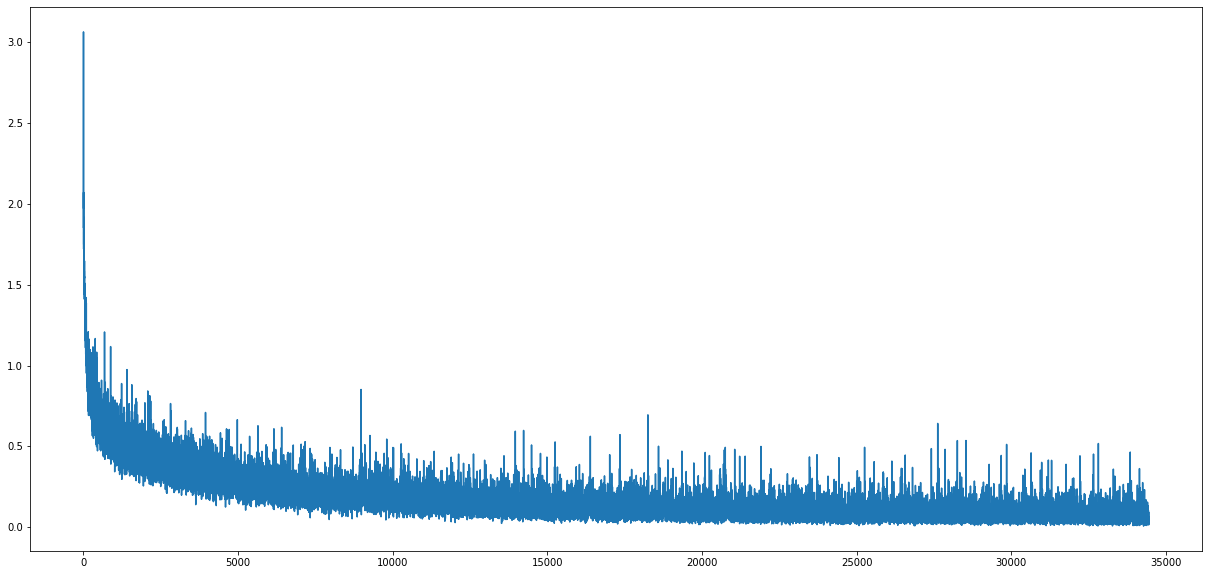

In [16]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train(model=model, epochs=130, loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
evalF1(loaderTest, model)
torch.save(model.state_dict(), "model1.pt")
plt.plot(loss_hist)

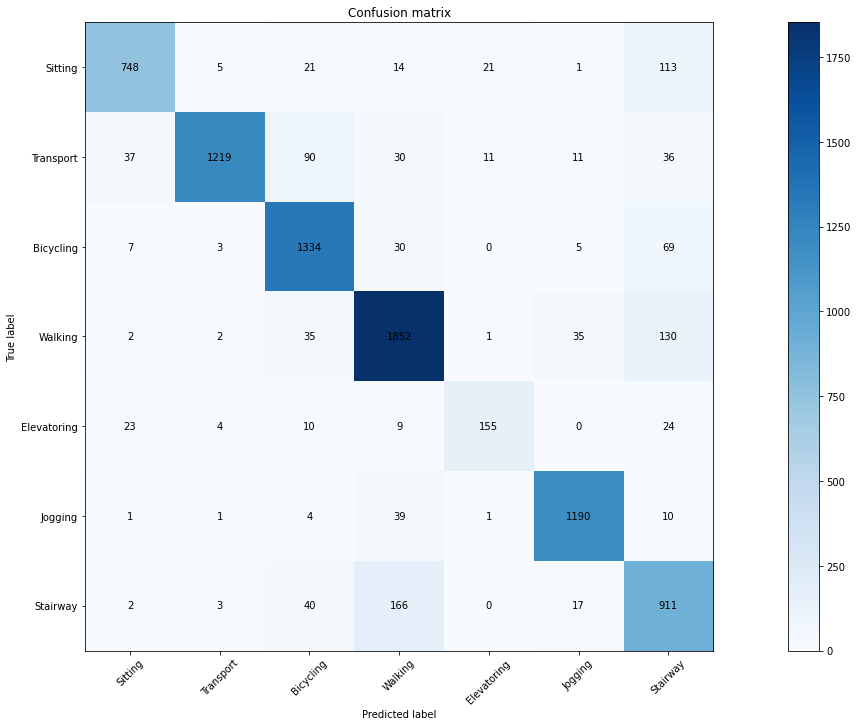

In [17]:
cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

# Model with 2 convolutional layer

In [18]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=32),
            activationFunction(),

            # torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=64),
            # activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1920, out_features=1000),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1000),
            torch.nn.Linear(in_features=1000, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


loss 330.25820875167847
loss 226.9761362671852
loss 185.74866807460785
loss 160.54315280914307
loss 141.8373549580574
loss 126.48710644245148
loss 115.91996866464615
loss 107.00368416309357
loss 98.80673977732658
loss 91.38231997191906
loss 86.45552645623684
loss 80.93326677381992
loss 77.8817707747221
loss 72.86964333057404
loss 68.12544213235378
loss 63.69945640861988
loss 60.97962771356106
loss 58.80162609368563
loss 55.8566437959671
loss 53.54335384815931
loss 52.560851365327835
loss 48.13224741816521
loss 46.494707494974136
loss 42.40574586391449
loss 40.765262462198734
loss 41.09457316622138
loss 39.939193200320005
loss 37.471980299800634
loss 36.62220887467265
loss 35.330195020884275
loss 35.291301030665636
loss 33.85940258204937
loss 30.666972164064646
loss 30.388603538274765
loss 28.828880071640015
loss 27.547571148723364
loss 28.265679147094488
loss 27.1958131454885
loss 24.95395523495972
loss 25.32093058153987
loss 24.984257865697145
loss 23.38275025971234
loss 24.4403900932

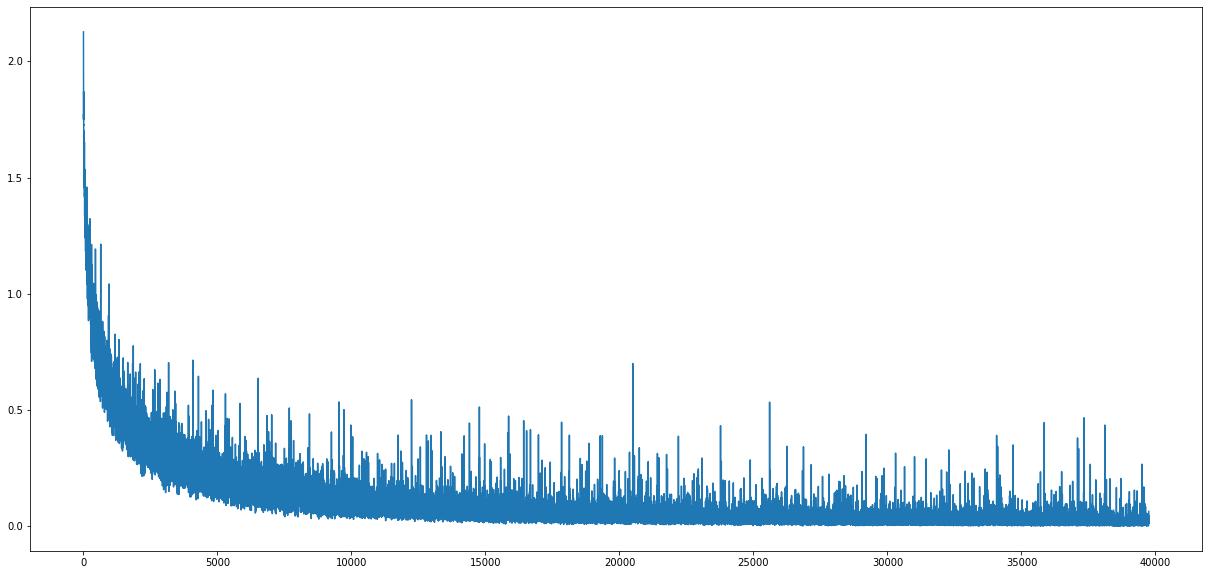

In [19]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train(model=model, epochs=150, loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-4), criterion=torch.nn.CrossEntropyLoss())
evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="test")
evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="train")
torch.save(model.state_dict(), "model2.pt")
plt.plot(loss_hist)

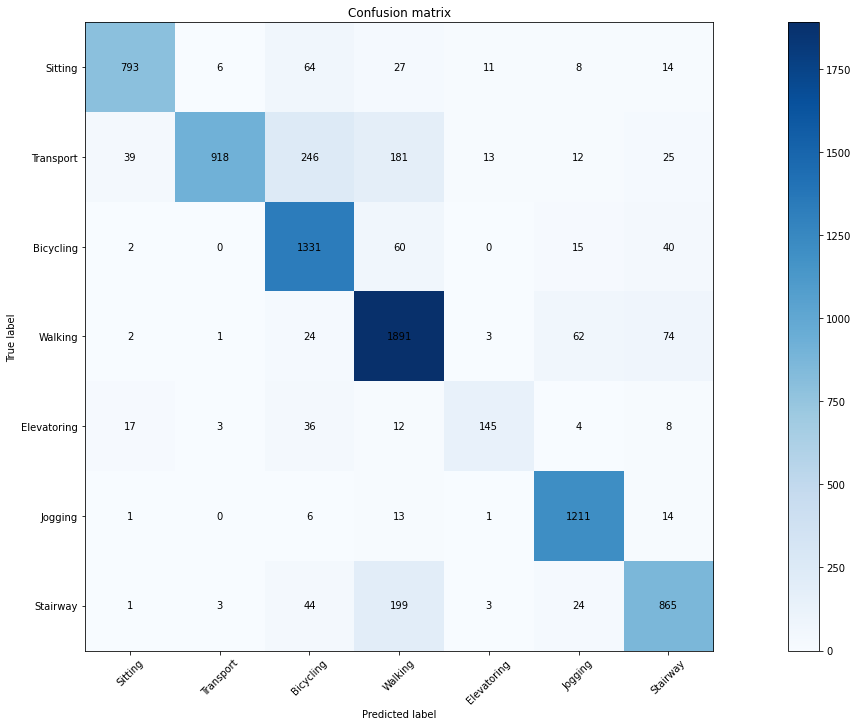

In [20]:
cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

# Model with 3 convolutional layer

In [21]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=32),
            activationFunction(),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=64),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1344, out_features=672),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=672),
            torch.nn.Linear(in_features=672, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


loss 301.8311733007431
loss 201.52291893959045
loss 164.49361580610275
loss 140.0934961438179
loss 125.01713958382607
loss 112.35606771707535
loss 103.48162057995796
loss 95.4259662926197
loss 87.62743702530861
loss 81.85982640087605
loss 78.84979651868343
loss 72.13981559872627
loss 66.23829750716686
loss 63.92422020435333
loss 61.50098644196987
loss 57.52398382127285
loss 55.19970405101776
loss 50.41791741549969
loss 47.78394067287445
loss 45.189940981566906
loss 43.76755391806364
loss 40.90048327669501
loss 39.749029852449894
loss 36.68514455109835
loss 36.626860700547695
loss 36.05873889476061
loss 32.78660653159022
loss 30.782633908092976
loss 30.940430644899607
loss 29.418669018894434
loss 29.99836715310812
loss 26.994572108611465
loss 26.40555389970541
loss 26.842506455257535
loss 25.343176757916808
loss 25.45367786474526
loss 24.21771297417581
loss 23.073552452027798
loss 23.01340206898749
loss 21.37465080432594
loss 21.05693230777979
loss 20.275470579974353
loss 19.48488076962

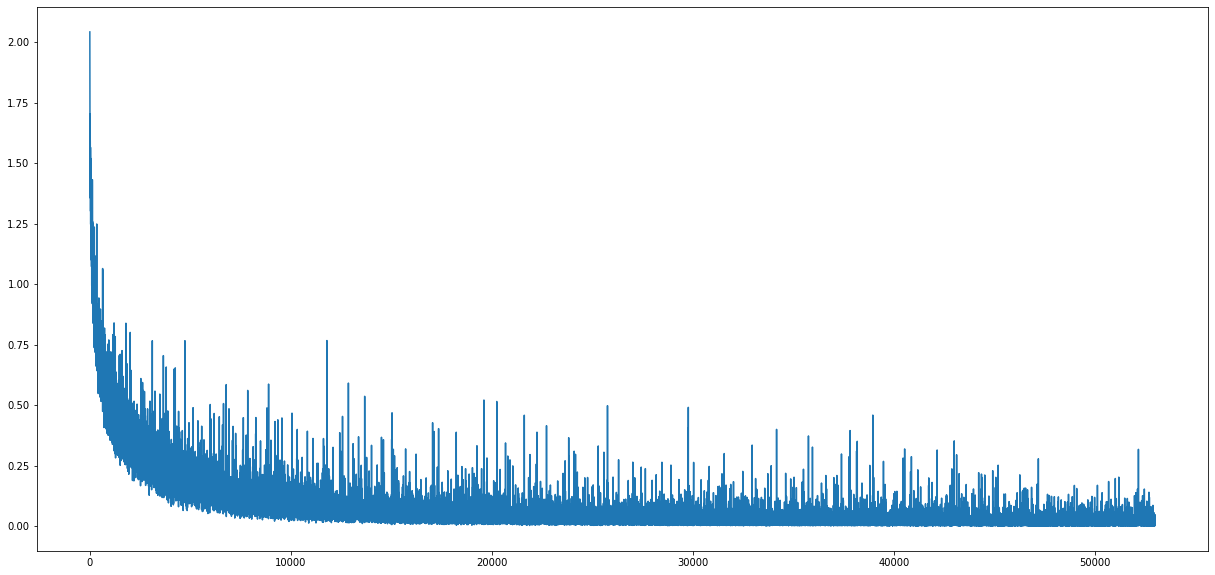

In [22]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train(model=model, epochs=200, loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-4), criterion=torch.nn.CrossEntropyLoss())
evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="test")
evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="train")
torch.save(model.state_dict(), "model3.pt")
plt.plot(loss_hist)

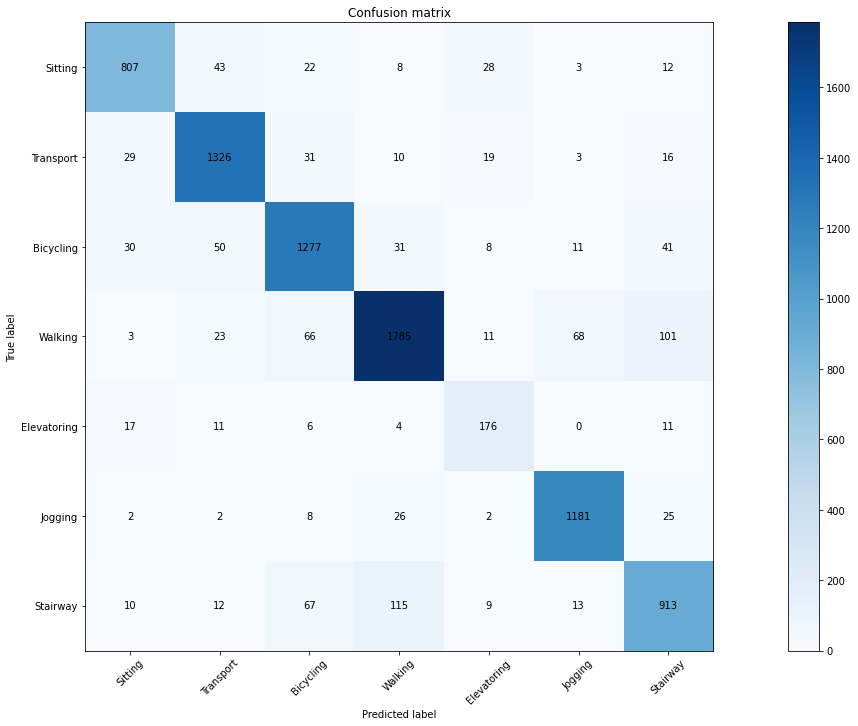

In [23]:
cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

# CNN with 1D input

In [24]:
data, target = next(iter(loaderTrain))
assert data[0].flatten().shape[0] == 43 * 13
print(43 * 13)

559


In [25]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=16),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=4496, out_features=2272),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=2272),
            torch.nn.Linear(in_features=2272, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = x.flatten(1)
        x = self.linStack(x)
        return x


In [26]:
def train1d(model, epochs:int, loader, optimizer, criterion):
    model.train()
    loss_hist = []
    loss = 0
    lossepoch = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
            # data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            lossepoch += loss.item()

            if epoch + 1 == epochs and loss_hist[-2] > loss_hist[-1]:
                best_model = model.state_dict()

        print("loss", lossepoch)
        lossepoch = 0
    
    model.load_state_dict(best_model)

    return loss_hist, model

In [27]:
def evalF1_1D(testLoader:torch.utils.data.DataLoader, model):
    targets = np.array([])
    preds = np.array([])
    for index, (data, target) in enumerate(testLoader):
        data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = torch.argmax(output, dim=1).cpu()
        pred = pred.numpy()
        target = target.cpu()
        target = target.numpy()
        targets = np.append(targets, target)
        preds = np.append(preds, pred)
    f1 = f1_score(targets, preds, average='macro')
    print("F1 score:", f1)
    return f1

In [28]:
def evalTest1D(model, testLoader, criterion, dataset_name:str):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testLoader:
            data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testLoader.dataset)
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        dataset_name, test_loss, correct, len(testLoader.dataset),
        100. * correct / len(testLoader.dataset)))
    accuracy = 100. * correct / len(testLoader.dataset)
    return accuracy

loss 321.9715227484703
loss 234.33833360671997
loss 201.0493022799492
loss 181.8885912001133
loss 172.265091329813
loss 161.3200625181198
loss 148.5667757987976
loss 137.81943014264107
loss 134.99481534957886
loss 128.39651826024055
loss 118.62341645359993
loss 112.02343453466892
loss 110.42160238325596
loss 106.89919766783714
loss 104.77715457975864
loss 100.10961548984051
loss 95.41531585156918
loss 96.974619358778
loss 89.1240389496088
loss 88.80817838013172
loss 87.5845982581377
loss 83.42345553636551
loss 81.58002179861069
loss 79.98096823692322
loss 78.0592891573906
loss 77.7100740224123
loss 74.16609655320644
loss 74.16817121207714
loss 69.96275275945663
loss 70.38913458585739
loss 65.7717806994915
loss 68.35202327370644
loss 67.79629924893379
loss 64.50279860943556
loss 63.193534933030605
loss 61.0298381075263
loss 60.23053485900164
loss 60.86996164917946
loss 57.43322368711233
loss 58.59890291839838
loss 55.42315002530813
loss 55.325629487633705
loss 54.85822959989309
loss 53.

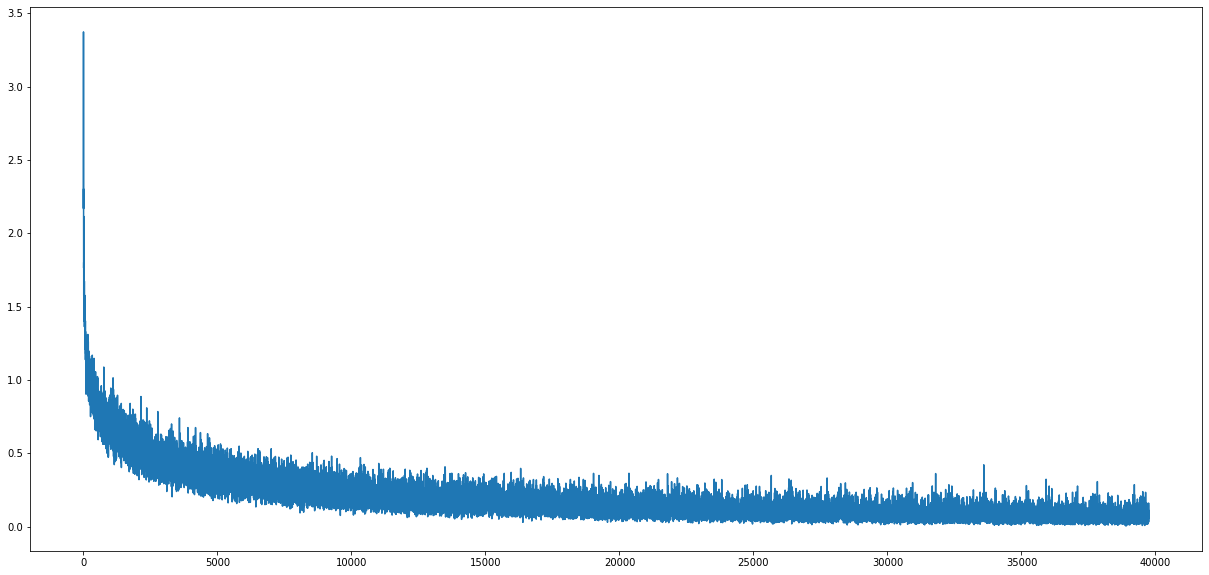

In [29]:
model = CNN(poolingFunction=torch.nn.MaxPool1d, bnFunction=torch.nn.BatchNorm1d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train1d(model, 150, loaderTrain, torch.optim.Adam(model.parameters(), lr=1e-3), torch.nn.CrossEntropyLoss())
evalTest1D(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="test")
evalTest1D(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="train")
torch.save(model.state_dict(), "model1d.pt")
plt.plot(loss_hist)

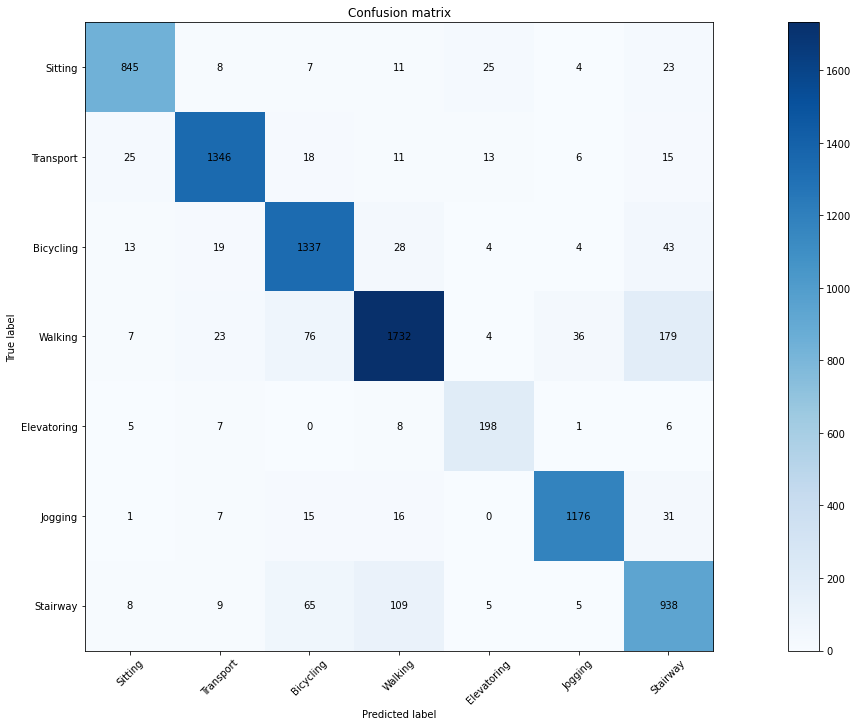

In [31]:
cm = confusionMatrix1D(loaderTest, model)
plotConfusionMatrix(cm)

# Model with three 2D convolutional layers and L2 regularization

In [32]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=32),
            activationFunction(),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=64),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1344, out_features=672),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=672),
            torch.nn.Linear(in_features=672, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


In [33]:
def trainL2(model, epochs:int, lm, loader, optimizer, criterion):
    model.train()
    loss_hist = []
    loss = 0
    lossepoch = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data = data.unsqueeze(1).float()
            # data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # adding l2
            weights = list(model.parameters())[0::2]
            l2_loss = 0

            for param in weights:
                l2_loss += torch.square(param).sum()

            l2_loss = lm * l2_loss
            
            # adding l1 to loss
            loss += l2_loss


            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            lossepoch += loss.item()

            if epoch + 1 == epochs and loss_hist[-2] > loss_hist[-1]:
                best_model = model.state_dict()

        print("loss", lossepoch)
        lossepoch = 0
    
    model.load_state_dict(best_model)

    return loss_hist, model

In [34]:
lms = [0.1, 0.01, 0.001, 0.0001, 0.00001]
lossHists = []
trainScores = []
testScores = []
f1Scores = []

for lm in lms:
    model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
    model.to(device)
    loss_hist, model = trainL2(model=model, epochs=150, lm=lm,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
    lossHists.append(loss_hist)
    testScore = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
    testScores.append(testScore)
    trainScore = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
    trainScores.append(trainScore)
    f1Score = evalF1(loaderTest, model)
    f1Scores.append(f1Score)

loss 16907.33303451538
loss 9059.723260879517
loss 4598.855005264282
loss 2186.301953315735
loss 1056.3965499401093
loss 640.7570812702179
loss 524.656280875206
loss 495.660479426384
loss 486.60028076171875
loss 482.97903633117676
loss 480.26950335502625
loss 479.89237797260284
loss 477.9983571767807
loss 476.44592559337616
loss 474.1455947160721
loss 474.02102267742157
loss 473.5540875196457
loss 472.2914046049118
loss 472.63825368881226
loss 471.50793981552124
loss 470.4171313047409
loss 468.2516849040985
loss 465.9755719900131
loss 464.8525105714798
loss 464.142501950264
loss 462.53651785850525
loss 462.65241622924805
loss 461.338613986969
loss 460.8779844045639
loss 459.6794196367264
loss 459.7539632320404
loss 459.12873661518097
loss 457.98440766334534
loss 458.95522582530975
loss 458.46980702877045
loss 458.082523226738
loss 457.70170080661774
loss 458.17128479480743
loss 457.5124241113663
loss 456.79055285453796
loss 457.81025326251984
loss 457.7039818763733
loss 457.71109294891

Lambda 0.1, Train: 27.036916811756722, Test: 26.94759206798867, F1: 0.10062818194897442
Lambda 0.01, Train: 67.4949095523357, Test: 66.66666666666667, F1: 0.5989452064447521
Lambda 0.001, Train: 89.07840764895093, Test: 84.50188857412654, F1: 0.7984350064785639
Lambda 0.0001, Train: 79.67952312096084, Test: 73.72521246458923, F1: 0.6723048666696865
Lambda 1e-05, Train: 75.68093959335438, Test: 69.90084985835693, F1: 0.588510707292569


Text(0.5, 1.0, 'Loss vs epoch for different lms')

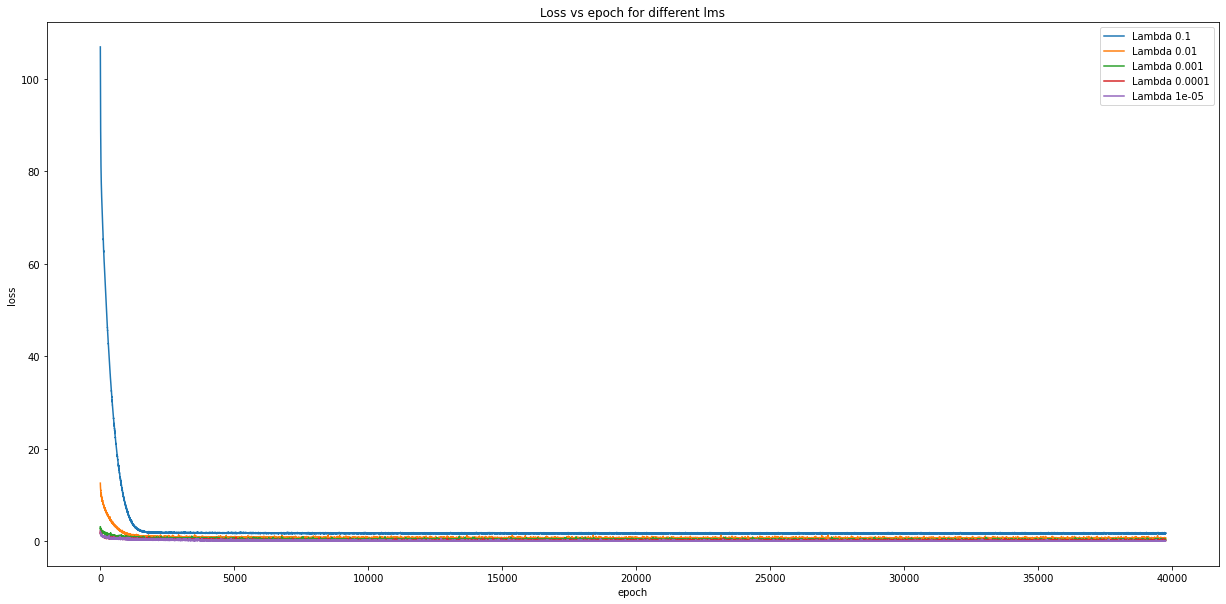

In [35]:
# plot lossHists for different lms and train/test/f1 scores
plt.figure()
for i in range(len(lossHists)):
    plt.plot(lossHists[i], label=f"Lambda {lms[i]}")
    print("Lambda " + str(lms[i]) + ", Train: " + str(trainScores[i]) + ", Test: " + str(testScores[i]) + ", F1: " + str(f1Scores[i]))
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss vs epoch for different lms")

# Model with 1D convolution

In [36]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=16),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=4496, out_features=2272),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=2272),
            torch.nn.Linear(in_features=2272, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = x.flatten(1)
        x = self.linStack(x)
        return x


In [37]:
def trainL2_1D(model, epochs:int, lm, loader, optimizer, criterion):
    model.train()
    loss_hist = []
    loss = 0
    lossepoch = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
            # data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # adding l2
            weights = list(model.parameters())[0::2]
            l2_loss = 0

            for param in weights:
                l2_loss += torch.square(param).sum()

            l2_loss = lm * l2_loss
            
            # adding l1 to loss
            loss += l2_loss


            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            lossepoch += loss.item()

            if epoch in list(range(epochs-10, epochs)) and loss_hist[-2] > loss_hist[-1]:
                best_model = model.state_dict()

        print("loss", lossepoch)
        lossepoch = 0
    
    model.load_state_dict(best_model)

    return loss_hist, model

In [38]:
lms = [0.1, 0.01, 0.001, 0.0001, 0.00001]
lossHists = []
trainScores = []
testScores = []
f1Scores = []

for lm in lms:
    model = CNN(poolingFunction=torch.nn.MaxPool1d, bnFunction=torch.nn.BatchNorm1d, activationFunction=torch.nn.ReLU)
    model.to(device)
    loss_hist, model = trainL2_1D(model=model, epochs=75, lm=lm,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
    lossHists.append(loss_hist)
    testScore = evalTest1D(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
    testScores.append(testScore)
    trainScore = evalTest1D(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
    trainScores.append(trainScore)
    f1Score = evalF1_1D(loaderTest, model)
    f1Scores.append(f1Score)

loss 47621.71487426758
loss 25921.989669799805
loss 12980.069011688232
loss 5909.6200914382935
loss 2514.9814257621765
loss 1132.0143587589264
loss 660.699300289154
loss 529.5133981704712
loss 498.85670244693756
loss 491.4924420118332
loss 489.2318605184555
loss 488.9076124429703
loss 488.3208729028702
loss 488.0677535533905
loss 487.8039917945862
loss 487.5106837749481
loss 487.27665066719055
loss 487.09891057014465
loss 486.9311583042145
loss 486.86305248737335
loss 486.78928577899933
loss 486.68303990364075
loss 486.6573795080185
loss 486.642165184021
loss 486.6355345249176
loss 486.6651875972748
loss 486.67383682727814
loss 486.67256259918213
loss 486.68630933761597
loss 486.69422912597656
loss 486.700320482254
loss 486.696821808815
loss 486.7578659057617
loss 486.7707430124283
loss 486.72907757759094
loss 486.7983536720276
loss 486.779580950737
loss 486.7631846666336
loss 486.84350299835205
loss 486.8996556997299
loss 486.7697809934616
loss 486.8423948287964
loss 486.9339332580566

Lambda 0.1, Train: 24.27479564434739, Test: 24.279981114258735, F1: 0.0558186233938917
Lambda 0.01, Train: 60.55714580812701, Test: 59.86779981114259, F1: 0.49091214644101033
Lambda 0.001, Train: 77.5990792929442, Test: 75.94428706326724, F1: 0.7115626532735834
Lambda 0.0001, Train: 83.6781066485673, Test: 79.85127478753542, F1: 0.7591516124727233
Lambda 1e-05, Train: 86.40776699029126, Test: 81.68083097261568, F1: 0.7854891250823


Text(0.5, 1.0, 'Loss vs epoch for different lms')

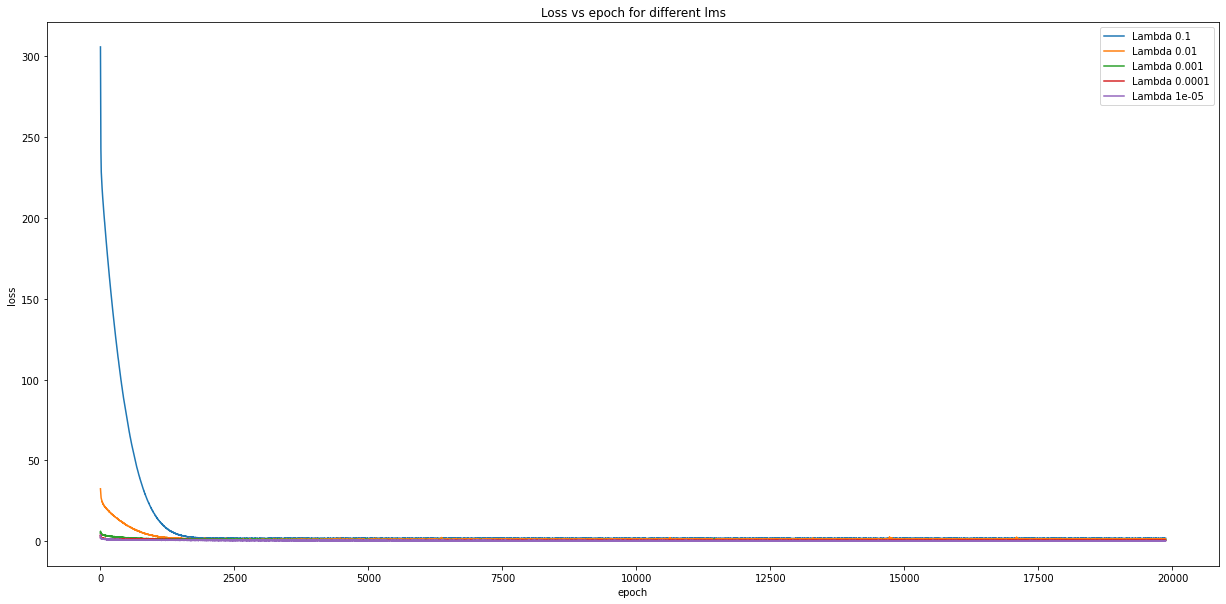

In [39]:
# plot lossHists for different lms and train/test/f1 scores
plt.figure()
for i in range(len(lossHists)):
    plt.plot(lossHists[i], label=f"Lambda {lms[i]}")
    print("Lambda " + str(lms[i]) + ", Train: " + str(trainScores[i]) + ", Test: " + str(testScores[i]) + ", F1: " + str(f1Scores[i]))
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss vs epoch for different lms")

# Bestes Modell 1D Input

In [40]:
model = CNN(poolingFunction=torch.nn.MaxPool1d, bnFunction=torch.nn.BatchNorm1d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = trainL2_1D(model=model, epochs=300, lm=0.00001,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-4), criterion=torch.nn.CrossEntropyLoss())
testScore = evalTest1D(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
trainScore = evalTest1D(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1Score = evalF1_1D(loaderTest, model)
torch.save(model.state_dict(), "best_model_1D_savgol.pt")

loss 321.4663380384445
loss 246.38489121198654
loss 213.53409260511398
loss 194.39571517705917
loss 179.5218465924263
loss 165.34011405706406
loss 157.17551907896996
loss 149.0697579085827
loss 143.8269483447075
loss 139.38226187229156
loss 132.48002988100052
loss 127.35580325126648
loss 124.50334995985031
loss 119.5197161436081
loss 118.45505648851395
loss 114.3924930691719
loss 111.92249634861946
loss 108.1828116774559
loss 108.3609227836132
loss 104.3412898182869
loss 99.58366772532463
loss 96.52499814331532
loss 96.64260590076447
loss 94.69058354198933
loss 92.307800501585
loss 92.96052098274231
loss 92.21363563835621
loss 88.31116124987602
loss 85.1394411623478
loss 85.37472555041313
loss 84.62723188102245
loss 85.13803714513779
loss 82.35646031796932
loss 80.85410615801811
loss 79.18444284796715
loss 79.33331499993801
loss 76.09284822642803
loss 75.39590680599213
loss 73.69385851919651
loss 71.93864123523235
loss 71.21463038027287
loss 70.14509716629982
loss 72.17503605782986
los

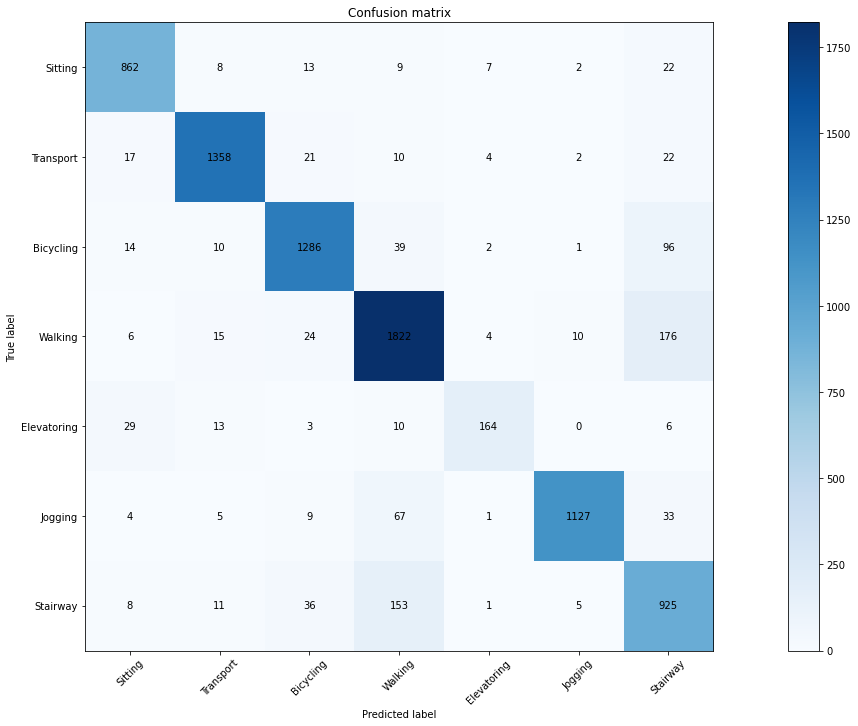

In [41]:
cm = confusionMatrix1D(loaderTest, model)
plotConfusionMatrix(cm)

# Bestes Modell 2D Input

## Modell

In [42]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            activationFunction(),
            # bnFunction(num_features=16),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            activationFunction(),
            # bnFunction(num_features=32),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            activationFunction(),
            # bnFunction(num_features=64),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1344, out_features=672),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=672),

            torch.nn.Linear(in_features=672, out_features=336),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=336),

            torch.nn.Linear(in_features=336, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


loss 423.2856549024582
loss 346.4394021034241
loss 304.56787753105164
loss 274.84180200099945
loss 253.31427133083344
loss 234.14301985502243
loss 219.3996106982231
loss 207.9434421658516
loss 195.93987667560577
loss 185.9822494983673
loss 177.5724419951439
loss 169.33641585707664
loss 163.14457187056541
loss 157.2853110730648
loss 150.70080056786537
loss 146.16629180312157
loss 141.67104321718216
loss 136.45944139361382
loss 132.04497948288918
loss 128.3468193113804
loss 125.0200252532959
loss 121.43159601092339
loss 118.86506325006485
loss 115.94034108519554
loss 112.55924561619759
loss 109.5975812971592
loss 107.5130278468132
loss 105.05377352237701
loss 102.31808066368103
loss 99.82327511906624
loss 97.53720086812973
loss 95.04391670227051
loss 93.35605096817017
loss 91.46297055482864
loss 89.05738574266434
loss 86.56559327244759
loss 85.03080074489117
loss 83.93991710245609
loss 82.39258101582527
loss 79.9120239764452
loss 77.01800608634949
loss 76.45168396830559
loss 75.481328949

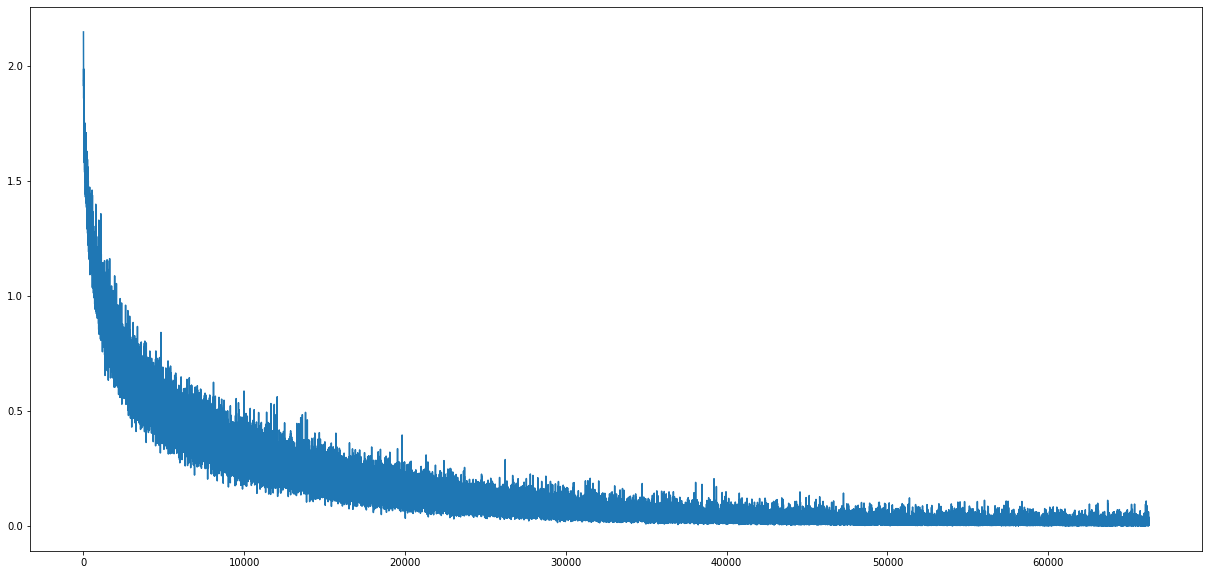

In [43]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = trainL2(model=model, epochs=250, lm=1e-10,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-5), criterion=torch.nn.CrossEntropyLoss())
testScore = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
trainScore = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1Score = evalF1(loaderTest, model)
plt.plot(loss_hist)
torch.save(model.state_dict(), "best_model_savgol.pt")

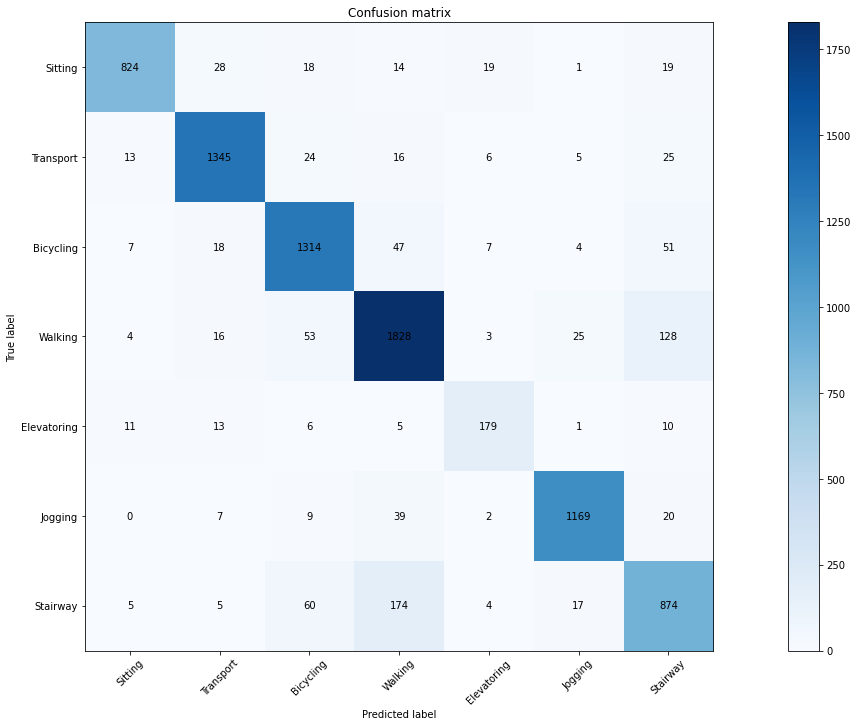

In [44]:
cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)